![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

# Destination Earth - OLCI Level 1B Reduced Resolution - Sentinel-3 - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[OLCI Level 1B Reduced Resolution - Sentinel-3](https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_1_ERR___NRT)

<div class="alert alert-block alert-success">
<h3>How to access and visualize OLCI Level 1B Reduced Resolution - Sentinel-3 </h3>
This notebook demonstrates how to search and access Sentinel-3 data using HDA and how to read and visualize it using satpy
</div>

Throughout this notebook, you will learn:

1. [Authenticate](#Authenticate): How to authenticate for searching and access *DEDL* collections. 
2. [Search OLCI data](#Search):  How to search *DEDL* data using datetime and bbox filters.
3. [Download OLCI data](#Download): How to download *DEDL* data through HDA.
4. [Read and visualize OLCI data](#Satpy): How to load process and visualize OlCI data using Satpy.


<div class="alert alert-block alert-warning">
<b> Prerequisites: </b>
<li> For filtering data inside collections : <a href="https://platform.destine.eu/"> DestinE user account</a> </li>
</div>

## Authenticate

We start off by importing the relevant modules for DestnE authentication, HTTP requests, json handling. 
Then we authenticate in DestinE.

In [4]:
import destinelab as deauth

In [5]:
import requests
import json
import os
from getpass import getpass

In [6]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


## Search

Once authenticated, we search a product matching our filters.

For this example, we search data for the [OLCI Level 1B Reduced Resolution - Sentinel-3](https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___) dataset. 

The corresponding collection ID in HDA for this dataset is: EO.EUM.DAT.SENTINEL-3.OL_1_ERR___.

In [7]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.EUM.DAT.SENTINEL-3.OL_1_ERR___"],
    "datetime": "2024-06-25T00:00:00Z/2024-06-30T00:00:00Z",
    "bbox":  [10,53,30,66]
})
if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

We can have a look at the metadata of the first products returned by the search.

In [8]:
from IPython.display import JSON

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

## Download

The product metadata contains the link to download it. We can use that link to download the selected product.
In this case we download the first product returned by our search.

In [9]:
from tqdm import tqdm
import time

assets = ["downloadLink"]

for asset in assets:
    download_url = product["assets"][asset]["href"]
    print(download_url)
    filename = product["id"]
    print(filename)
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)

https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___/items/S3B_OL_1_ERR____20240625T083313_20240625T091737_20240625T110705_2664_094_278______PS2_O_NR_004/download?provider=dedl
S3B_OL_1_ERR____20240625T083313_20240625T091737_20240625T110705_2664_094_278______PS2_O_NR_004
downloading S3B_OL_1_ERR____20240625T083313_20240625T091737_20240625T110705_2664_094_278______PS2_O_NR_004


925MB [00:01, 588MB/s] 


### Unfold the product 

In [10]:
del response
import os
import zipfile

zf=zipfile.ZipFile(filename)
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

## Read and visualize OLCI data using Satpy


The Python package satpy supports reading and loading data from many input files. 

Below the installation and import of useful modules and packages.

In [11]:
pip install --quiet satpy pyspectral

Note: you may need to restart the kernel to use updated packages.


In [12]:
from datetime import datetime
from satpy import find_files_and_readers
from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers

import pyresample
import pyspectral

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

### Read data

We can read the downloaded data using the "olci_l1b" satpy reader

In [13]:


files = find_files_and_readers(sensor="olci",
                               start_time=datetime(2024, 6, 25, 0, 0),
                               end_time=datetime(2024, 6, 30, 0, 0),
                               base_dir=".",
                               reader="olci_l1b")

scn = Scene(filenames=files)
# print available datasets
scn.available_dataset_names()

['Oa01',
 'Oa02',
 'Oa03',
 'Oa04',
 'Oa05',
 'Oa06',
 'Oa07',
 'Oa08',
 'Oa09',
 'Oa10',
 'Oa11',
 'Oa12',
 'Oa13',
 'Oa14',
 'Oa15',
 'Oa16',
 'Oa17',
 'Oa18',
 'Oa19',
 'Oa20',
 'Oa21',
 'altitude',
 'humidity',
 'latitude',
 'longitude',
 'mask',
 'quality_flags',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'sea_level_pressure',
 'solar_azimuth_angle',
 'solar_zenith_angle',
 'total_columnar_water_vapour',
 'total_ozone']

We can print the available datasets for the loaded scene.

With the function load(), you can specify an individual band by name. If you then select the loaded band, you see the xarray.DataArray band object

In [14]:
# load bands 
scn.load(['humidity','total_ozone'])
scn['humidity']

<xarray.DataArray 'array-85855ab6062d8c1037a4b549271045c6' (y: 15138, x: 1217)>
dask.array<array, shape=(15138, 1217), dtype=float32, chunksize=(4096, 1217), chunktype=numpy.ndarray>
Coordinates:
    crs      object +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes: (12/17)
    coordinates:          latitude longitude
    long_name:            Relative humidity at 850 hPa
    standard_name:        relative_humidity
    units:                %
    valid_max:            100.0
    valid_min:            0.0
    ...                   ...
    start_time:           2024-06-25 08:33:13
    end_time:             2024-06-25 09:17:37
    reader:               olci_l1b
    area:                 Shape: (15138, 1217)\nLons: <xarray.DataArray 'long...
    _satpy_id:            DataID(name='humidity', resolution=300, modifiers=())
    ancillary_variables:  []

### Visualize data

We can visualize the available datasets on a map.

In [15]:
import matplotlib.pyplot as plt
from pyresample.kd_tree import resample_nearest
from pyresample.geometry import AreaDefinition


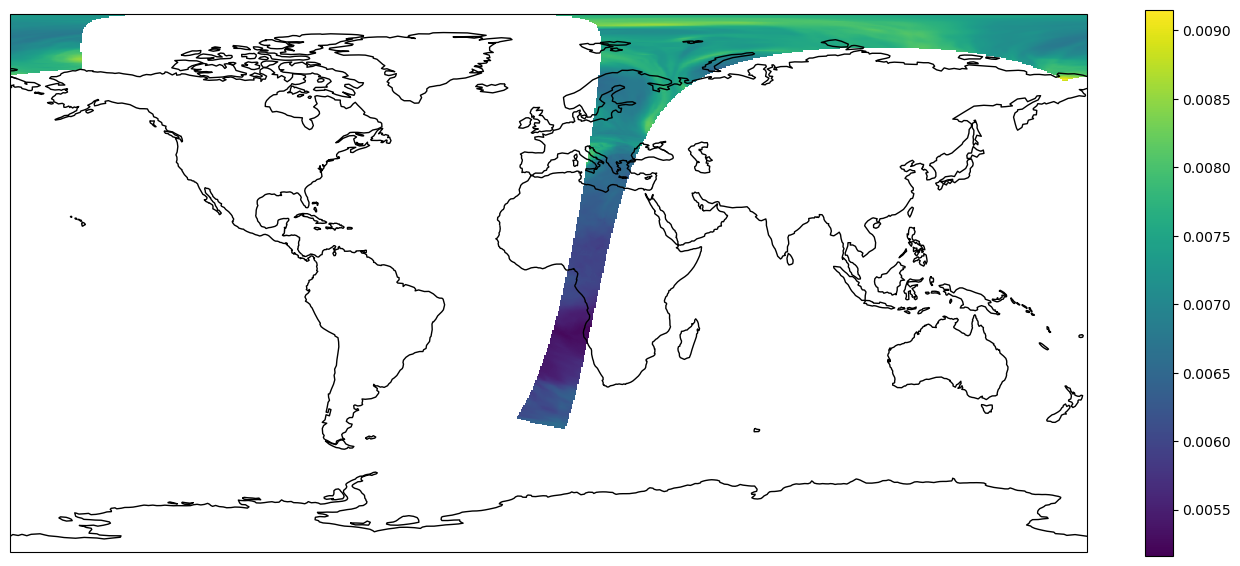

In [16]:
#area definition
area_id = 'worldeqc30km'
description = 'World in 3km, platecarree'
proj_id = 'eqc'
projection = {'proj': 'eqc', 'ellps': 'WGS84'}
width = 820
height = 410
area_extent = (-20037508.3428, -10018754.1714, 20037508.3428, 10018754.1714)
area_def = AreaDefinition(area_id, description, proj_id, projection,
                          width, height, area_extent)

#scene 
lons, lats = scn["total_ozone"].area.get_lonlats()
swath_def = pyresample.geometry.SwathDefinition(lons, lats)
total_ozone = scn["total_ozone"].data.compute()
result = resample_nearest(swath_def, total_ozone, area_def, radius_of_influence=20000, fill_value=None)

#cartopy
plt.rcParams['figure.figsize'] = [15, 15]
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
coastlines = ax.coastlines()  
ax.set_global()

#plot
img = plt.imshow(result, transform=crs, extent=crs.bounds, origin='upper')
# Calculate (height_of_image / width_of_image)
im_ratio = result.shape[0]/result.shape[1]
 
# Plot vertical colorbar
plt.colorbar(fraction=0.047*im_ratio)
plt.show()